In [28]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest


df = pd.read_csv("../Donnees/cleaned_data.csv")


# Visualisation

## Données numériques

In [2]:
number_columns = ["rating", "retirement", "time", "price", "review_count", "rating_value", "twenty_four_hours", "all_time"]
dfn = df[number_columns]

In [3]:
forest = IsolationForest()
outliers = forest.fit_predict(dfn)

In [6]:
dfn = dfn.drop(index=np.where(outliers==-1)[0])
scaler = StandardScaler()  # Standardize numerical variables
dfn = pd.DataFrame(scaler.fit_transform(dfn), columns=number_columns)


In [ ]:
sns.pairplot(dfn)
plt.savefig("pairplot.png")

<Axes: >

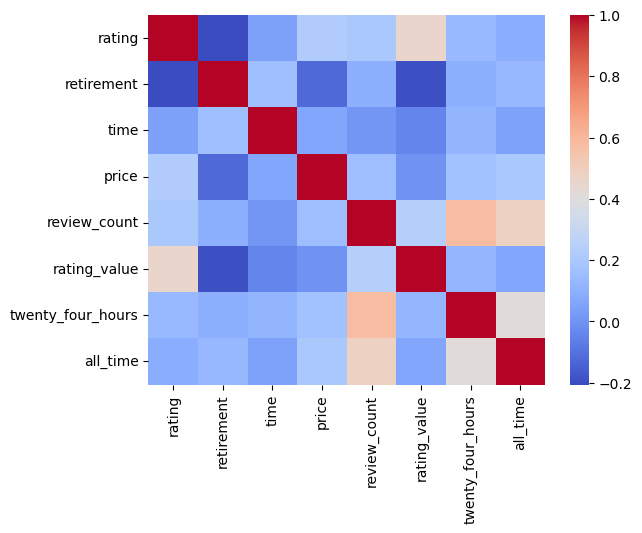

In [5]:
sns.heatmap(dfn.corr(),cmap="coolwarm")

Text(0.5, 0, 'Price')

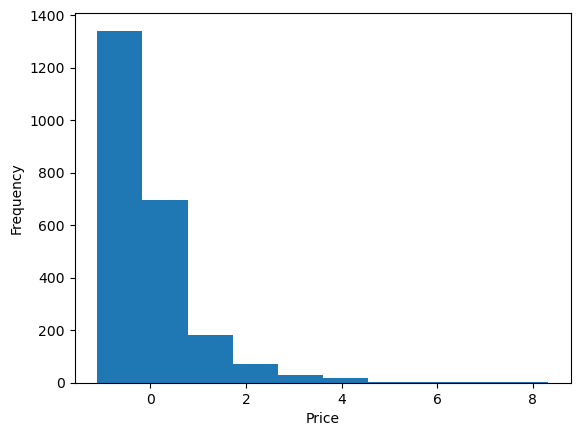

In [6]:
dfn["price"].plot.hist()
plt.xlabel("Price")

Text(0.5, 0, 'Rating')

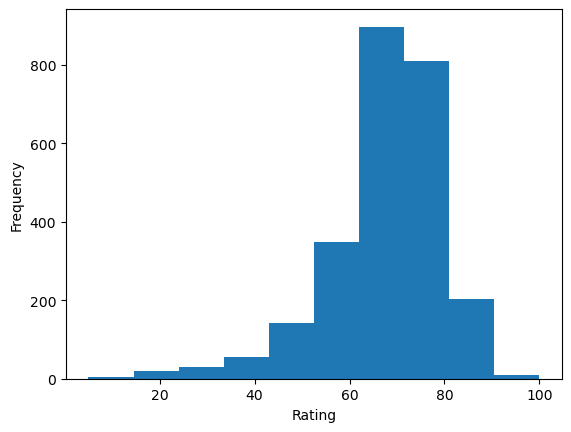

In [7]:
df['rating'].plot.hist()
plt.xlabel("Rating")

<Axes: >

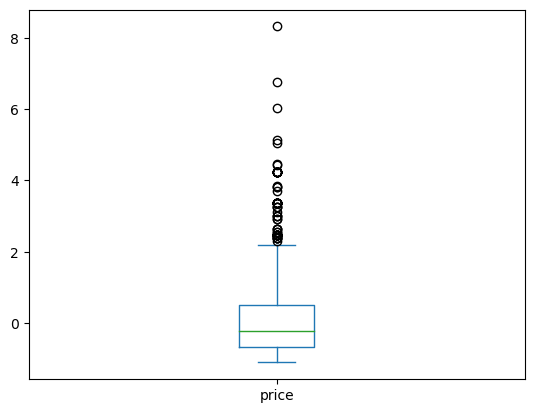

In [8]:
dfn["price"].plot.box()

In [9]:
df.describe()

,hltb_id,rating,retirement,date,time,price,pourcentage_pos,review_count,rating_value,twenty_four_hours,all_time,steam_id
count,2519.000000,2519.000000,2519.000000,2519.000000,2519.000000,2519.000000,2519.000000,2.519000e+03,2519.000000,2519.000000,2.519000e+03,2.519000e+03
mean,31252.208416,67.546645,7.964629,2013.496626,34.175824,14.332189,82.342993,1.160413e+04,8.357285,920.874553,6.176490e+03,4.510454e+05
std,19325.401165,12.104395,5.992263,5.464294,282.550657,49.237890,13.019623,6.203766e+04,1.261397,14871.881692,3.475548e+04,3.160946e+05
min,38.000000,5.000000,0.500000,1987.000000,1.000000,0.000000,14.000000,1.100000e+01,2.000000,0.000000,0.000000e+00,5.000000e+01
25%,13307.500000,62.000000,3.800000,2012.000000,5.000000,4.990000,76.000000,3.875000e+02,7.000000,5.000000,1.080000e+02,2.558550e+05
50%,30088.000000,70.000000,6.400000,2015.000000,10.250000,9.990000,85.000000,1.534000e+03,9.000000,15.000000,4.840000e+02,3.930800e+05
75%,49988.000000,75.000000,10.000000,2017.000000,22.825000,19.500000,92.000000,5.314000e+03,9.000000,71.000000,2.174500e+03,6.100100e+05
max,63616.000000,100.000000,42.700000,2023.000000,9949.500000,2357.360000,100.000000,2.180390e+06,10.000000,712630.000000,1.291328e+06,2.450820e+06


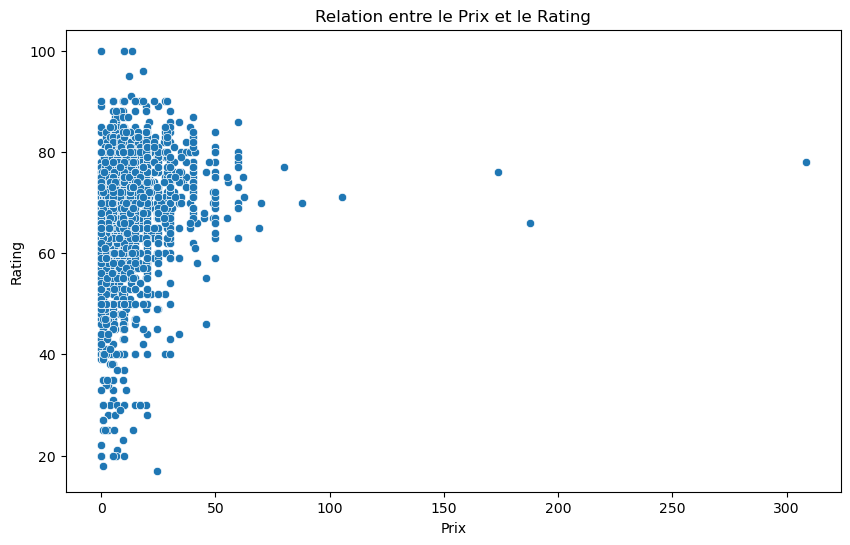

In [12]:
plt.figure(figsize=(10, 6))
df2 = df.drop(index=np.where(outliers==-1)[0])
sns.scatterplot(x=df2['price'], y=df2['rating'])
plt.title('Relation entre le Prix et le Rating')
plt.xlabel('Prix')
plt.ylabel('Rating')
plt.show()

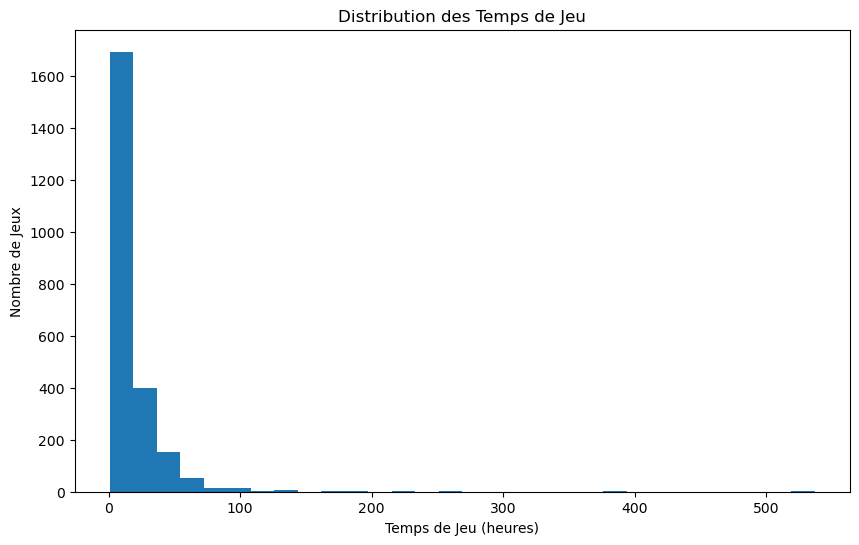

In [72]:
plt.figure(figsize=(10, 6))
df2['time'].plot.hist(bins=30)
plt.title('Distribution des Temps de Jeu')
plt.xlabel('Temps de Jeu (heures)')
plt.ylabel('Nombre de Jeux')
plt.show()

c:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


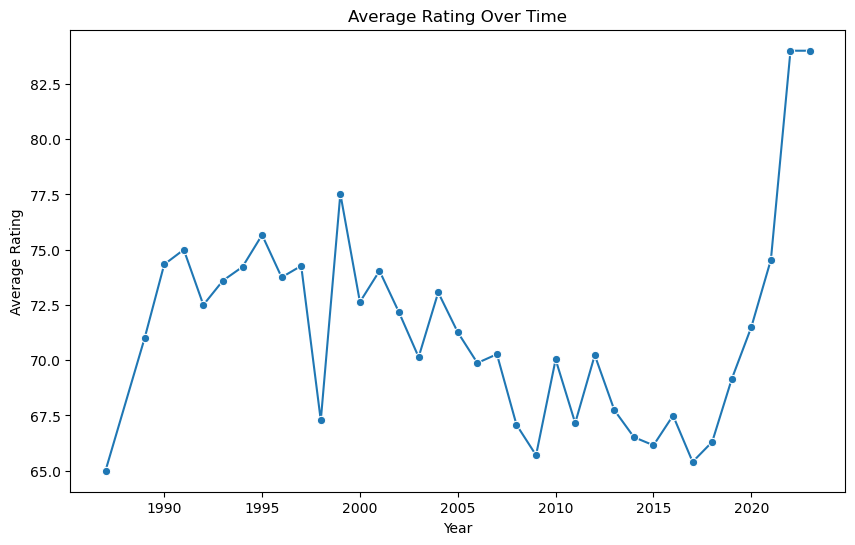

c:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


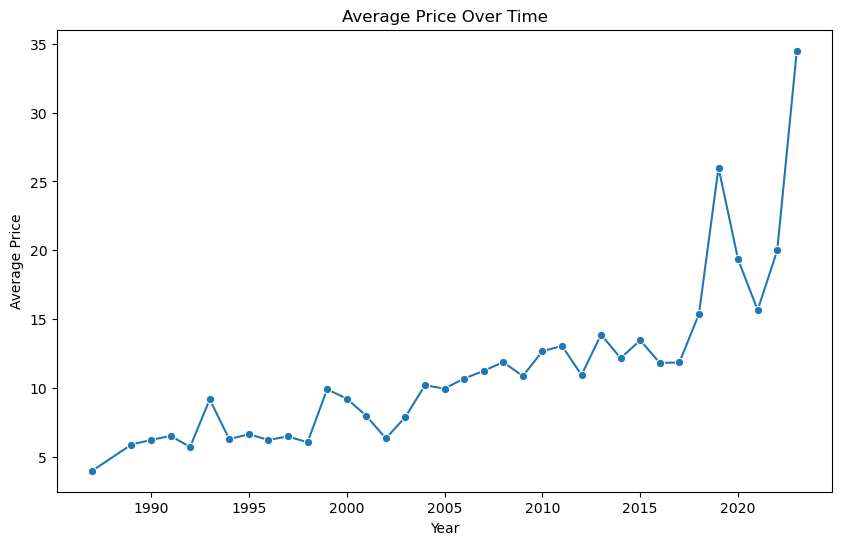

In [15]:
# Convertir la colonne 'date' en datetime

# Résumé par année
annual_data = df2.groupby('date').agg({
    'rating': 'mean',
    'price': 'mean',
    'all_time': 'sum'
}).reset_index()

# Visualisation des tendances
plt.figure(figsize=(10, 6))
sns.lineplot(data=annual_data, x='date', y='rating', marker='o')
plt.title('Average Rating Over Time')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=annual_data, x='date', y='price', marker='o')
plt.title('Average Price Over Time')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.show()


## Description

c:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


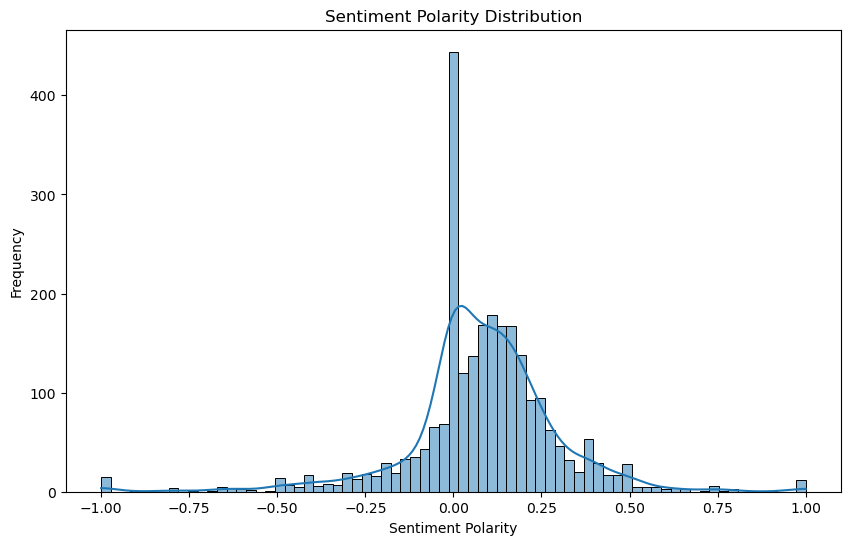

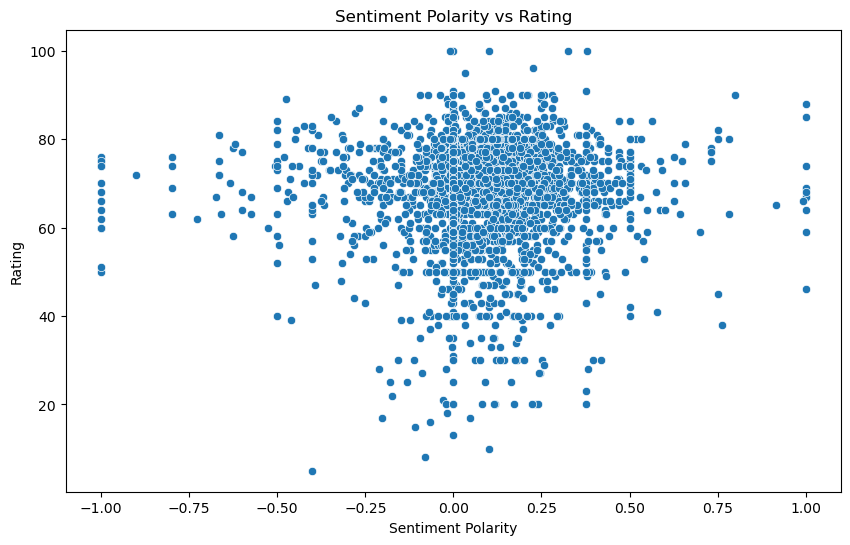

In [29]:
from textblob import TextBlob

# Calcul du sentiment des descriptions
df_s = df.copy()
df_s['sentiment'] = df['description'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Visualisation de la distribution des sentiments
plt.figure(figsize=(10, 6))
sns.histplot(df_s['sentiment'].dropna(), kde=True)
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

# Corrélation entre sentiment et rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_s['sentiment'], y=df_s['rating'])
plt.title('Sentiment Polarity vs Rating')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Rating')
plt.show()


-> les jeux ont tendance à faire des descriptions neutres, en général légèrement positives

c:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\rapha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


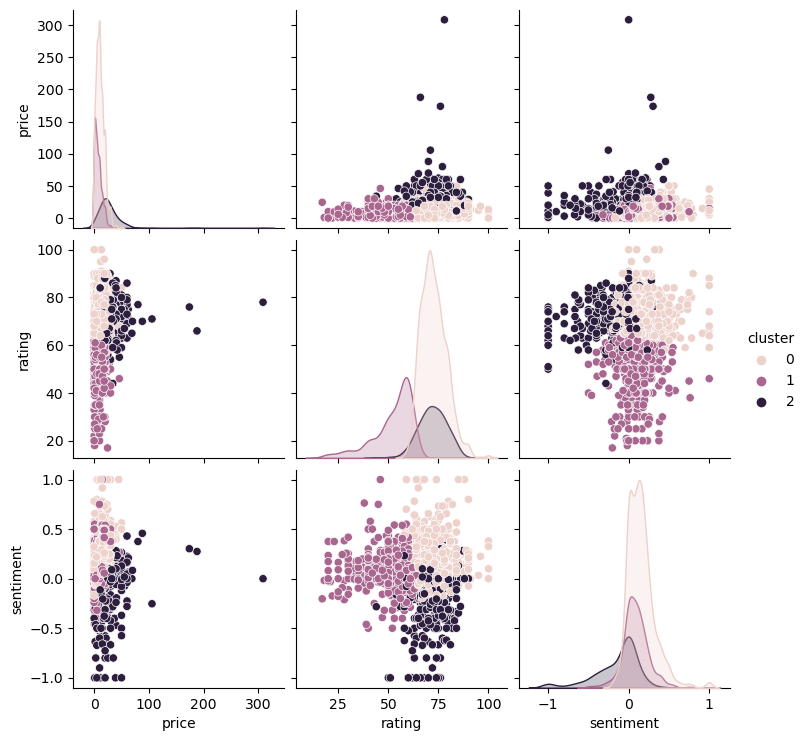

In [30]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Sélection des caractéristiques pour le clustering
df_s = df_s.drop(index=np.where(outliers==-1)[0])
features = df_s[['price', 'rating', 'sentiment']]

# Normalisation des données
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Clustering
kmeans = KMeans(n_clusters=3, n_init =10)
df_s['cluster'] = kmeans.fit_predict(features_scaled)

# Visualisation
sns.pairplot(df_s, hue='cluster', vars=['price', 'rating', 'sentiment'])
plt.show()


In [32]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Vectorisation des descriptions
df = df.dropna()
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X_desc = vectorizer.fit_transform(df['description'])

# LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_desc)

# Affichage des thèmes
for i, topic in enumerate(lda.components_):
    print(f'Thème {i}:')
    print([vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]])


Thème 0:
['le', 'en', 'vos', 'pour', 'la', 'votre', 'les', 'vous', 'des', 'et']
Thème 1:
['avec', 'pour', 'une', 'jeu', 'en', 'la', 'le', 'les', 'des', 'et']
Thème 2:
['features', 'games', 'like', 'life', 'play', 'time', 'story', 'new', 'world', 'game']
Thème 3:
['en', 'est', 'vous', 'dans', 'une', 'des', 'les', 'le', 'la', 'et']
Thème 4:
['enemies', 'different', 'time', 'battle', 'players', 'unique', 'play', 'world', 'new', 'game']


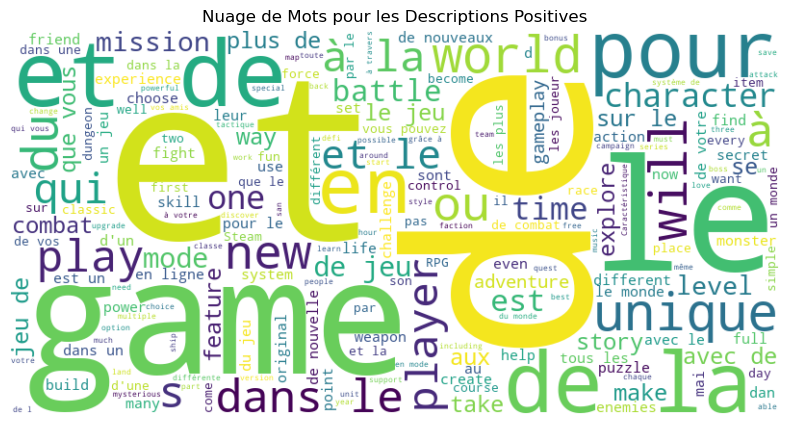

In [33]:
from wordcloud import WordCloud

# Nuage de mots pour les descriptions positives
text_pos = ' '.join(df_s[df_s['sentiment'] > 0]['description'])
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(text_pos)

# Visualisation
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de Mots pour les Descriptions Positives')
plt.show()


## Données catégorielles

In [5]:
import ast

def dummies_list(df):
    df = df.astype(str).apply(ast.literal_eval)
    df2 = pd.get_dummies(pd.DataFrame(df.values.tolist()), prefix_sep='', prefix='')
    merged_columns = {}
    for col_name, col_data in df2.items():
        if col_name.strip() not in merged_columns:
            merged_columns[col_name.strip()] = col_data
        else:
            merged_columns[col_name.strip()] += col_data
    merged_platform = pd.DataFrame(merged_columns)
    return merged_platform

def get_dummies_genres(X):
    X = X.dropna(axis="rows")
    X['genres'] = X['genres'].astype(str).apply(ast.literal_eval)

    X_genre = dummies_list(X.genres)

    return X_genre

def X_with_dummies(X,column):
    X = X.dropna(axis="rows")
    X[column] = X[column].astype(str).apply(ast.literal_eval) # certaines listes sont enregistrées en str donc on remet tout en listes

    X_column = dummies_list(X[column])

    X = X.drop(column,axis=1)

    X = pd.merge(X,X_column,how = "left",left_index=True,right_index=True)

    return X

### Genres

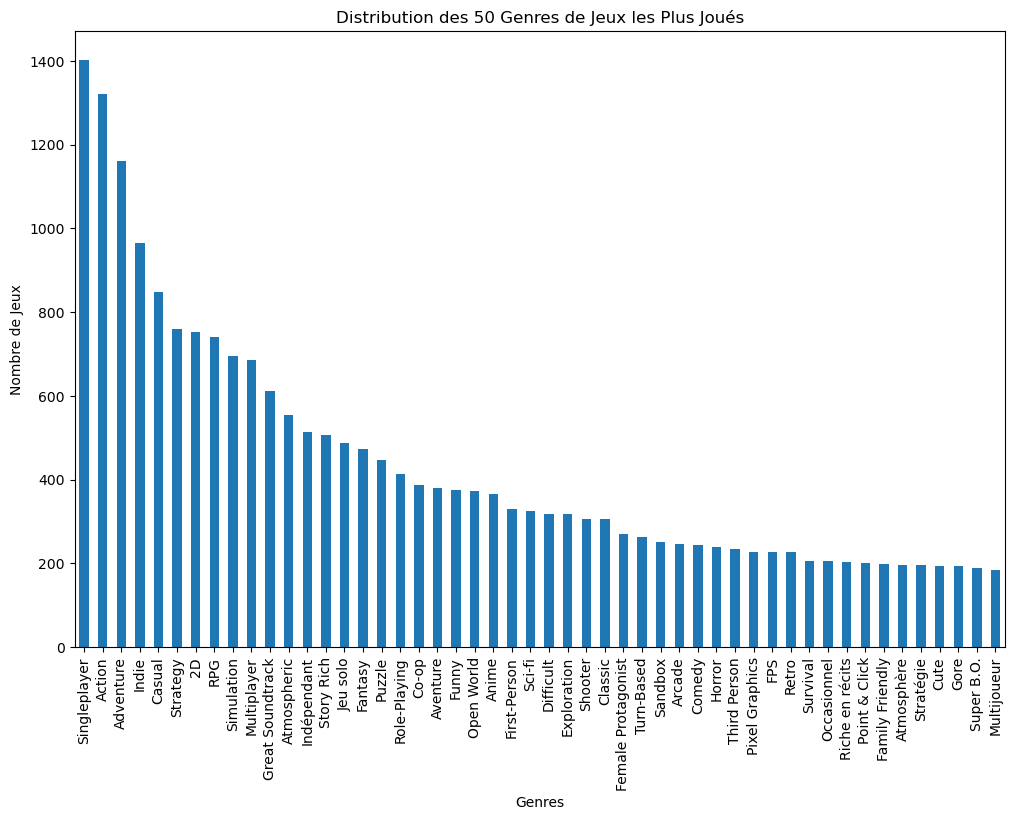

In [6]:
# Créer une nouvelle colonne pour chaque genre avec une valeur binaire
genres_df = dummies_list(df['genres'])

# Calculer le nombre de jeux pour chaque genre
genre_counts = genres_df.sum().sort_values(ascending=False)

# Sélectionner les 50 genres les plus joués
top_50_genres = genre_counts.head(50)

# Visualiser les 50 genres les plus joués
plt.figure(figsize=(12, 8))
top_50_genres.plot(kind='bar')
plt.title('Distribution des 50 Genres de Jeux les Plus Joués')
plt.xlabel('Genres')
plt.ylabel('Nombre de Jeux')
plt.show()

<Figure size 1200x800 with 0 Axes>

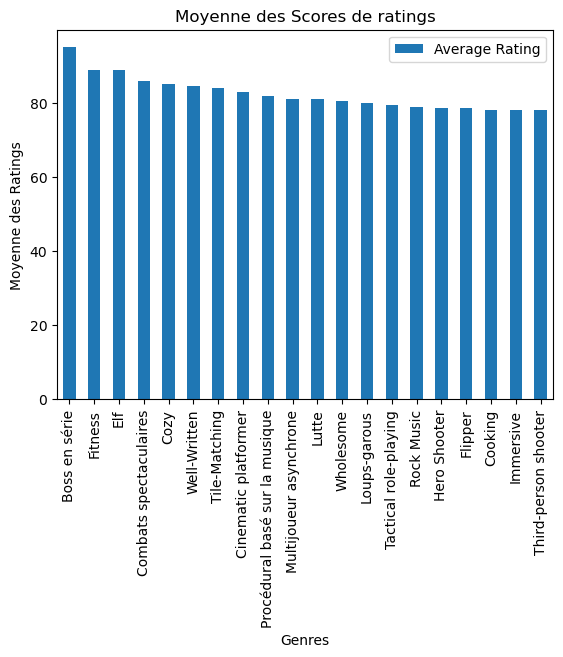

In [7]:
rating_genres = df[['rating','genres']]
rating_genres = X_with_dummies(rating_genres,'genres')
genres_df = rating_genres.drop(columns=['rating'])

average_ratings_by_genre = {}

# Calculer la moyenne des ratings pour chaque genre
for genre in genres_df.columns:
    average_rating = rating_genres[rating_genres[genre] == 1]['rating'].mean()
    average_ratings_by_genre[genre] = average_rating

# Convertir le dictionnaire en DataFrame
average_ratings_by_genre_df = pd.DataFrame(list(average_ratings_by_genre.items()), columns=['Genre', 'Average Rating'])

average_ratings_by_genre_df = average_ratings_by_genre_df.sort_values(by=['Average Rating'],ascending=False)

top_20 = average_ratings_by_genre_df.head(20)

plt.figure(figsize=(12, 8))
top_20.plot.bar(x='Genre', y='Average Rating')
plt.title('Moyenne des Scores de ratings')
plt.xlabel('Genres')
plt.ylabel('Moyenne des Ratings')
plt.show()


### Platform

Comparaison entre les plateformes qui ont le plus de jeux vs celles qui ont le plus de joueurs

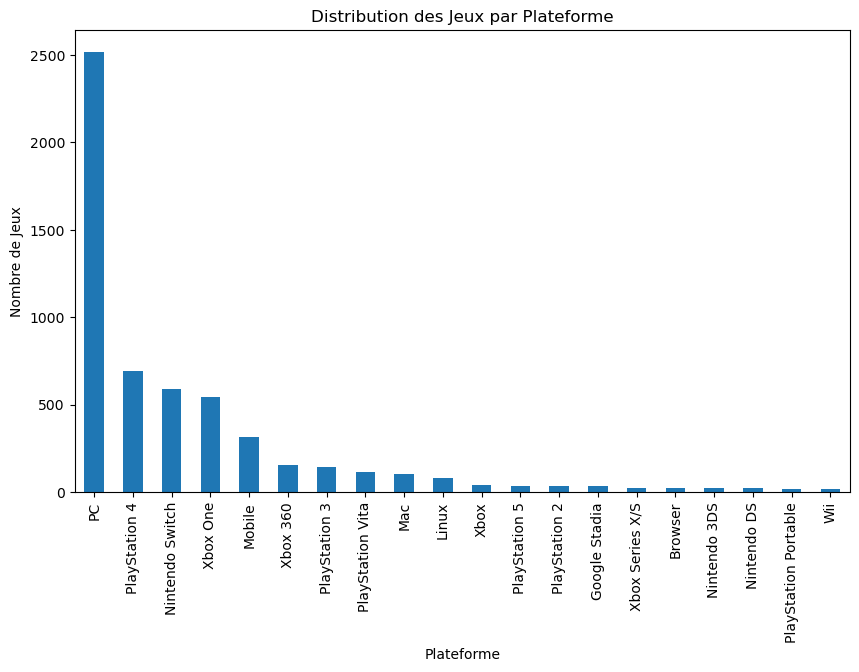

In [8]:
import matplotlib.pyplot as plt


platform_df = dummies_list(df['platform'])

# Calculer le nombre de jeux pour chaque genre
plat_counts = platform_df.sum().sort_values(ascending=False)

# Sélectionner les 50 genres les plus joués
top_plat = plat_counts.head(20)

# Visualiser les 50 genres les plus joués
plt.figure(figsize=(10, 6))
top_plat.plot(kind='bar')
plt.title('Distribution des Jeux par Plateforme')
plt.xlabel('Plateforme')
plt.ylabel('Nombre de Jeux')
plt.show()

<Figure size 1200x800 with 0 Axes>

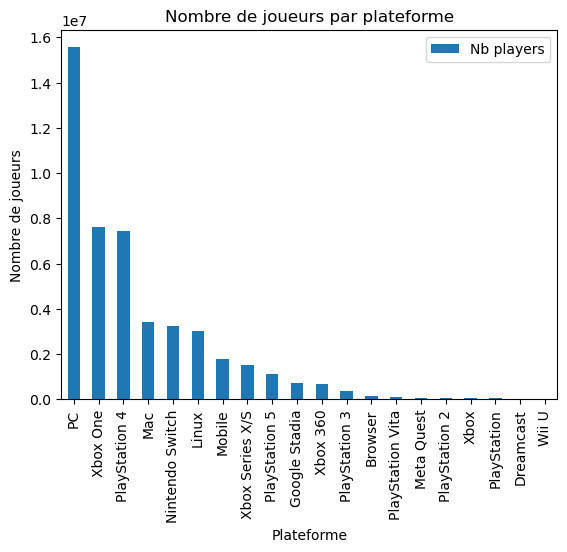

In [12]:
players_plat = df[['all_time','platform']]
players_plat = X_with_dummies(players_plat,'platform')
plat_df = players_plat.drop(columns=['all_time'])

nb_players_by_plat = {}

# Calculer la moyenne des ratings pour chaque genre
for platform in plat_df.columns:
    nb_players = players_plat[players_plat[platform] == 1]['all_time'].sum()
    nb_players_by_plat[platform] = nb_players

# Convertir le dictionnaire en DataFrame
nb_players_by_plat_df = pd.DataFrame(list(nb_players_by_plat.items()), columns=['Platform', 'Nb players'])

nb_players_by_plat_df = nb_players_by_plat_df.sort_values(by=['Nb players'],ascending=False)

top_20 = nb_players_by_plat_df.head(20)

plt.figure(figsize=(12, 8))
top_20.plot.bar(x='Platform', y='Nb players')
plt.title('Nombre de joueurs par plateforme')
plt.xlabel('Plateforme')
plt.ylabel('Nombre de joueurs')
plt.show()

# Réduction des colonnes (genres)

In [11]:
def reduce_genre_columns(df,nb_tags=150):

    X_genre = get_dummies_genres(df)
    X_genre = X_genre.drop(index=np.where(outliers==-1)[0])
    colsum = list(zip(X_genre.columns, X_genre.sum()))
    to_drop = sorted(colsum, key=lambda x:x[1], reverse=True)[nb_tags:]
    to_drop = [e[0] for e in to_drop]
    X_genre = X_genre.drop(to_drop, axis=1)
    return X_genre

X_genre = reduce_genre_columns(df,799)


C:\Users\rapha\AppData\Local\Temp\ipykernel_15380\704342877.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['genres'] = X['genres'].astype(str).apply(ast.literal_eval)


<Axes: >

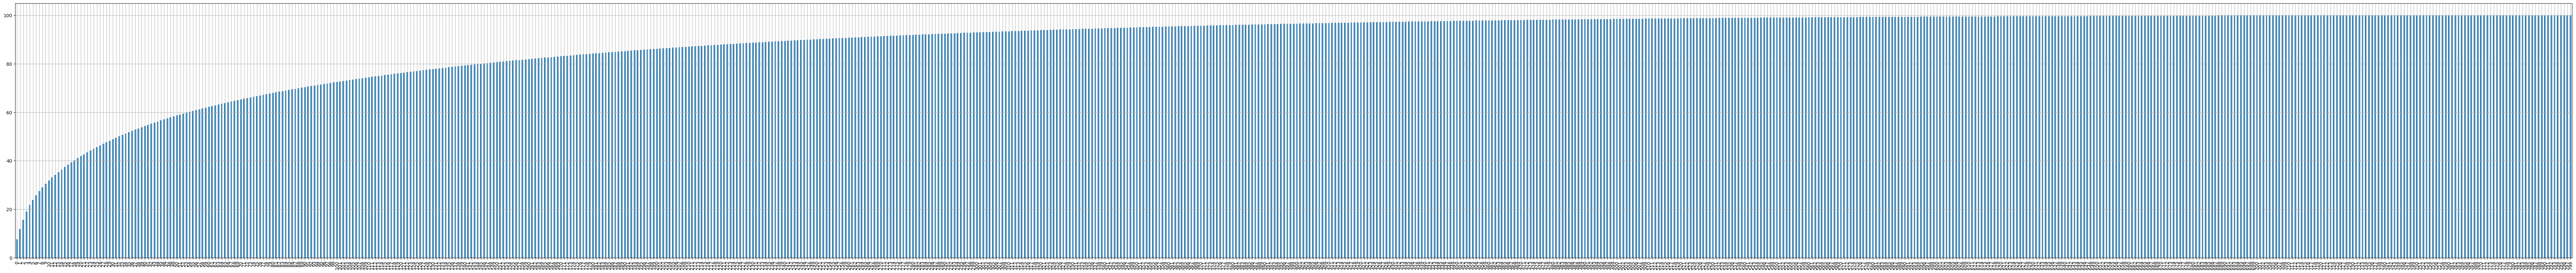

In [12]:
#X_genre = X_genre.drop(index=np.where(outliers==-1)[0])


# reduction de dimension

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_genre)

summary = pd.DataFrame({"variances":pca.explained_variance_,"ratio":pca.explained_variance_ratio_,"cumulative ratio":np.cumsum(pca.explained_variance_ratio_)})
(100*summary['cumulative ratio']).plot.bar(figsize=(100,10),grid=True)


In [28]:
def get_X_with_genres_after_pca(X_genre,nb_components):
    pca = PCA()
    pca.fit(X_genre)
    pca_data = pca.transform(X_genre)
    pca_data = pd.DataFrame(pca_data).drop(list(range(nb_components,799)),axis='columns')
    df_with_genres_simplifie = pd.merge(df,pca_data,how = "left",left_index=True,right_index=True)
    df_with_genres_simplifie = df_with_genres_simplifie.drop("genres",axis=1)
    df_with_genres_simplifie.columns = df_with_genres_simplifie.columns.astype(str)
    return df_with_genres_simplifie 

2338    799


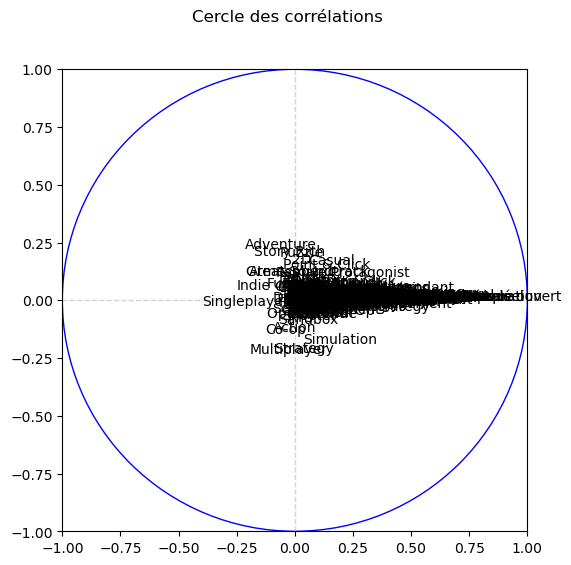

In [14]:

# Cercle de correlation 
n = X_genre.shape[0] # nb of individuals
p = X_genre.shape[1] # nb of variables
print(n, '  ', p)
eigval = (n-1) / n * pca.explained_variance_ # eigen values
sqrt_eigval = np.sqrt(eigval)
corvar = np.zeros((p,p)) # empty matrix for coordinates
for k in range(p):
    corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]
# on modifie pour avoir un dataframe
coordvar = pd.DataFrame({'id': X_genre.columns, 'COR_1': corvar[:,0], 'COR_2': corvar[:,1]})

fig, axes = plt.subplots(figsize = (6,6))
fig.suptitle("Cercle des corrélations")
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)
# Ajout des axes
axes.axvline(x = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
axes.axhline(y = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
# Ajout des noms des variables
for j in range(p):
    axes.text(coordvar["COR_1"][j],coordvar["COR_2"][j], coordvar["id"][j])
# Ajout du cercle
plt.gca().add_artist(plt.Circle((0,0),1,color='blue',fill=False))

plt.show()

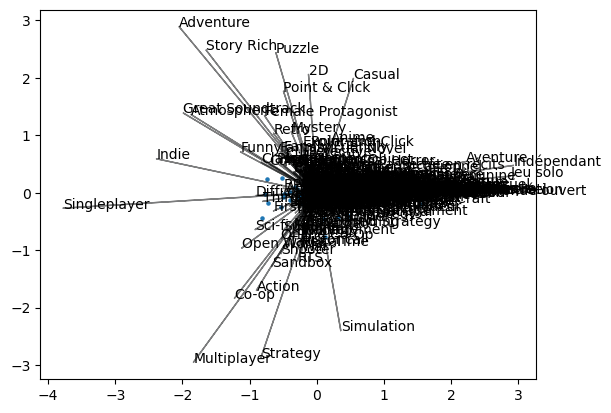

In [15]:
pca_data = pca.transform(X_genre)

plt.scatter(pca_data[0],pca_data[1],s=5)
for i in range(pca.components_.shape[1]):
    plt.arrow(0,0,pca.components_[0,i]*10,pca.components_[1,i]*10,alpha=0.5)
    plt.text(pca.components_[0,i]*10,pca.components_[1,i]*10,X_genre.columns[i])

# Analyses

### PCA sur données numériques

<Axes: >

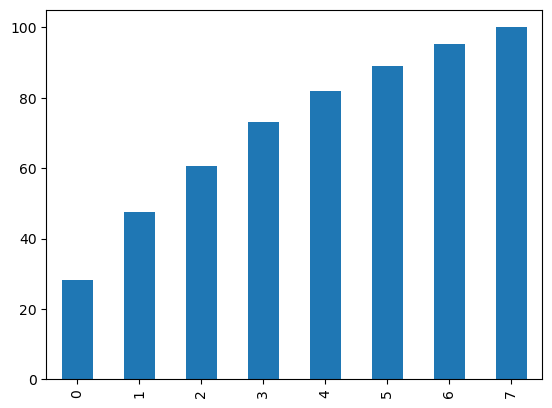

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(dfn)
data = scaler.transform(dfn) # normalisation
dataframe = pd.DataFrame(data)
pca = PCA()
pca.fit(dataframe)

summary = pd.DataFrame({"variances":pca.explained_variance_,"ratio":pca.explained_variance_ratio_,"cumulative ratio":np.cumsum(pca.explained_variance_ratio_)})
(100*summary['cumulative ratio']).plot.bar()

2343    8


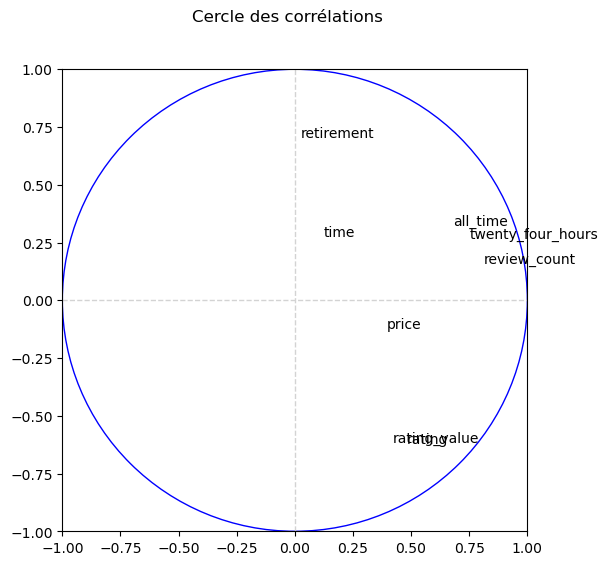

In [18]:
pca_data = pca.transform(dataframe)
pca_data = pd.DataFrame(pca_data).drop([5,6,7],axis='columns') # on ne garde que les 3 premières dimensions (80% de l'information)

# Cercle de correlation 
n = data.shape[0] # nb of individuals
p = data.shape[1] # nb of variables
print(n, '  ', p)
eigval = (n-1) / n * pca.explained_variance_ # eigen values
sqrt_eigval = np.sqrt(eigval)
corvar = np.zeros((p,p)) # empty matrix for coordinates
for k in range(p):
    corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]
# on modifie pour avoir un dataframe
coordvar = pd.DataFrame({'id': dfn.columns, 'COR_1': corvar[:,0], 'COR_2': corvar[:,1]})

fig, axes = plt.subplots(figsize = (6,6))
fig.suptitle("Cercle des corrélations")
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)
# Ajout des axes
axes.axvline(x = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
axes.axhline(y = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
# Ajout des noms des variables
for j in range(p):
    axes.text(coordvar["COR_1"][j],coordvar["COR_2"][j], coordvar["id"][j])
# Ajout du cercle
plt.gca().add_artist(plt.Circle((0,0),1,color='blue',fill=False))

plt.show()

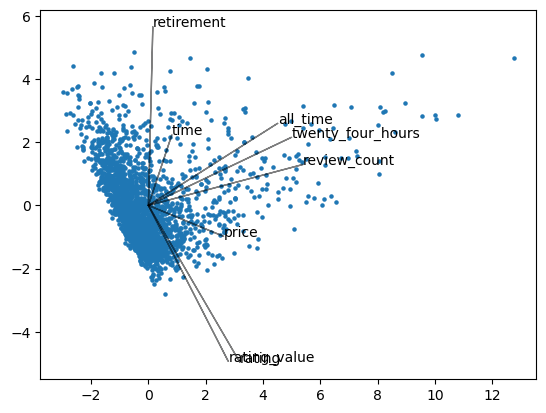

In [19]:
plt.scatter(pca_data[0],pca_data[1],s=5)
for i in range(pca.components_.shape[1]):
    plt.arrow(0,0,pca.components_[0,i]*10,pca.components_[1,i]*10,alpha=0.5)
    plt.text(pca.components_[0,i]*10,pca.components_[1,i]*10,dfn.columns[i])

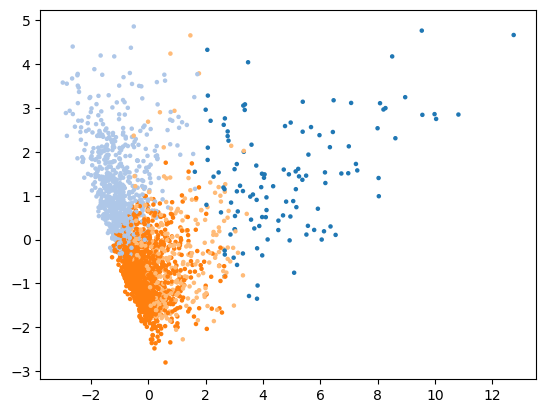

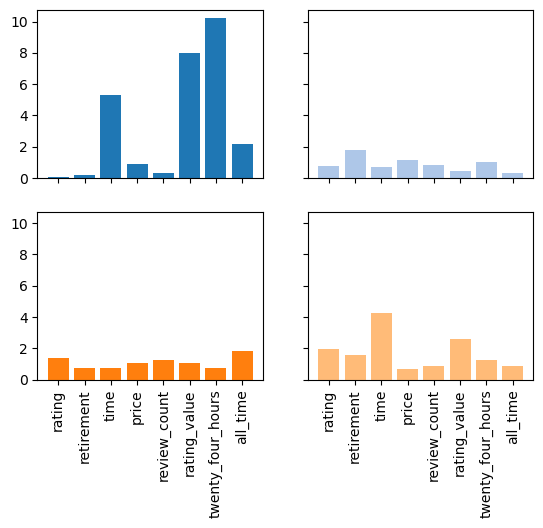

In [23]:
from sklearn.cluster import KMeans
tab20 = plt.get_cmap('tab20')

km = KMeans(n_clusters=4,n_init=10)
pred = km.fit_predict(data)
plt.scatter(pca_data[0],pca_data[1],color = [tab20.colors[pred[i]] for i in range(len(pca_data))],s=5)


real_centers = np.exp(pca.inverse_transform(km.cluster_centers_))
fig, axs = plt.subplots(km.n_clusters//2, 2, sharey=True,sharex=True)
for i,k in enumerate(real_centers):
    axs.flatten()[i].bar(range(len(k)),k,color=tab20.colors[i])
    axs.flatten()[i].set_xticks(range(len(k)))
    axs.flatten()[i].set_xticklabels(dfn.columns,rotation="vertical")

## Prédiction d'une variable en fonction des autres

### Prédiction du rating en fonction du genre, de la platforme, de la date de sortie et du prix.

Test avec les colonnes trouvées par la PCA pour le genre :

C:\Users\rapha\AppData\Local\Temp\ipykernel_15380\894188407.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = X[column].astype(str).apply(ast.literal_eval) # certaines listes sont enregistrées en str donc on remet tout en listes
C:\Users\rapha\AppData\Local\Temp\ipykernel_15380\894188407.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = X[column].astype(str).apply(ast.literal_eval) # certaines listes sont enregistrées en str donc on remet tout en listes
C:\Users\rapha\AppData\Loc

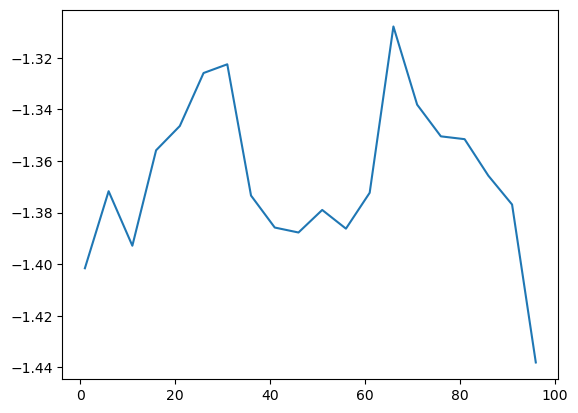

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

L = []
nb_genres_gardes = range(1,100,5)
for n in nb_genres_gardes:
    df_with_genres_simplifie = get_X_with_genres_after_pca(X_genre,n)

    X = df_with_genres_simplifie.drop(columns=['hltb_id','pourcentage_pos','review_count','retirement', 'rating_value', 'all_time','twenty_four_hours', 'players_by_time','title','description', 'steam_id'])
    
    X = X_with_dummies(X,"platform")
    y = X['rating']
    X = X.drop("rating",axis=1)
    #X = X.drop(index=np.where(outliers==-1)[0])
    #y = y.drop(index=np.where(outliers==-1)[0])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    y_train = list(y_train)
    y_test = list(y_test)


    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)

    r2 = r2_score(y_test, y_pred)
    L.append(r2)

plt.plot(nb_genres_gardes,L)


Test avec les colonnes de base :

In [ ]:
def X_with_dummies_genre_platform(X,nb_genre=10):
    X = X.dropna(axis="rows")
    X['platform'] = X['platform'].astype(str).apply(ast.literal_eval) # listes sont enregistrées en str donc on remet tout en listes
    X['genres'] = X['genres'].astype(str).apply(ast.literal_eval)

    X_platform = dummies_list(X.platform)

    #X_genre = dummies_list(X.genre)
    X_genre = get_dummies_genres(X)
    X_genre = reduce_genre_columns(X,nb_genre)

    #X = X.drop("platform",axis=1)
    X = X.drop(columns=["platform","genres"])

    X = pd.merge(X,X_platform,how = "left",left_index=True,right_index=True)
    X = pd.merge(X,X_genre,how = "left",left_index=True,right_index=True)

    return X

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

#df = df.dropna()
X = df[['platform', 'genres', 'date', 'price','time','rating']].copy()
X = X_with_dummies_genre_platform(X)
X = X.drop(index=np.where(outliers==-1)[0])
X = X.dropna()

y = X['rating'].copy()
X = X.drop(columns=['rating'])



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = list(y_train)
y_test = list(y_test)


model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)
print("MSE:",mse, "R2:",r2)



MSE: 122.68510697732731 R2: 0.1905749787388259


Feature importance :

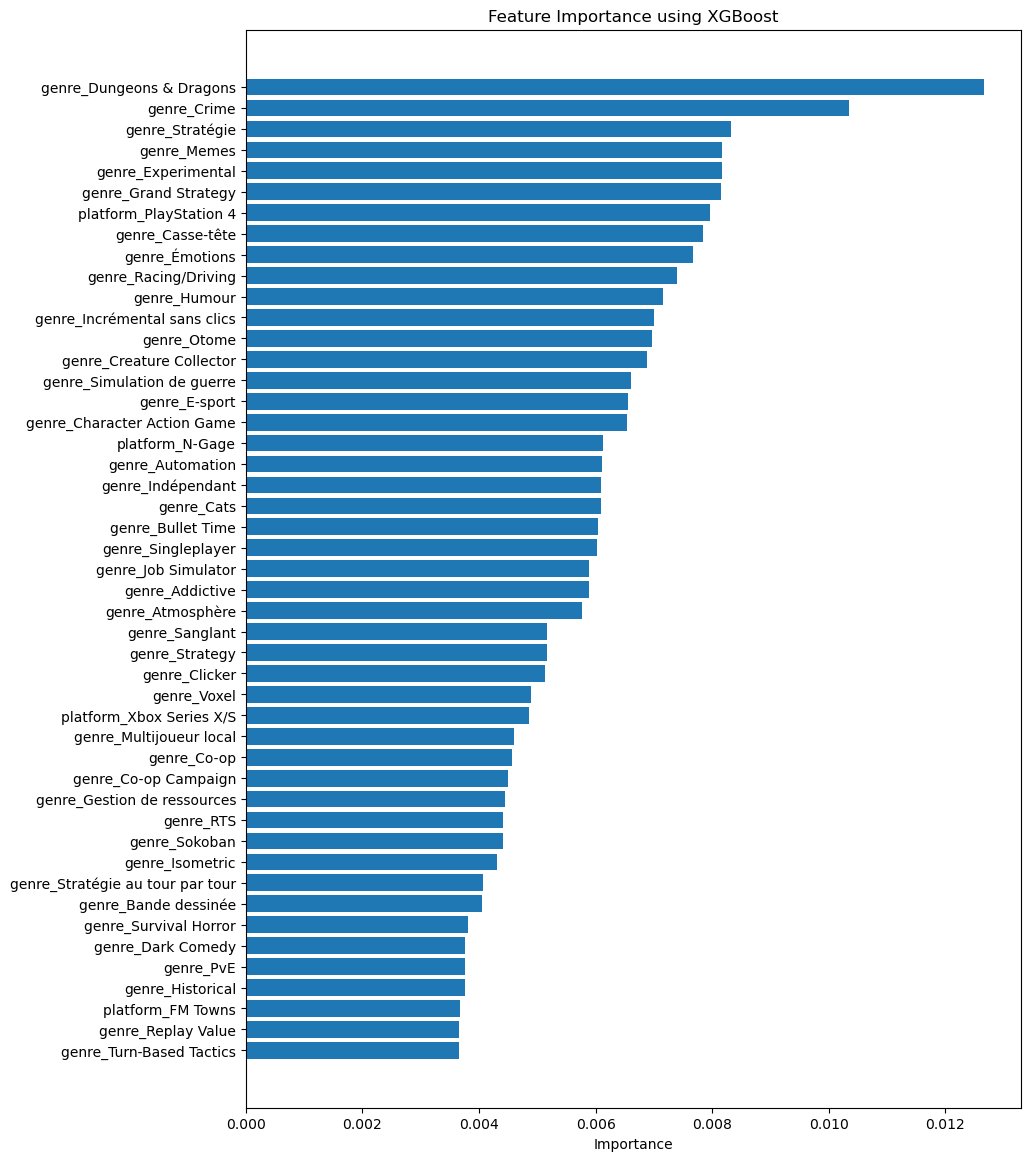

                               Feature  Importance
736           genre_Dungeons & Dragons    0.012661
2382                       genre_Crime    0.010351
4458                   genre_Stratégie    0.008322
3179                       genre_Memes    0.008167
1062                genre_Experimental    0.008164
1092              genre_Grand Strategy    0.008151
6008            platform_PlayStation 4    0.007967
651                   genre_Casse-tête    0.007837
5958                    genre_Émotions    0.007666
2599              genre_Racing/Driving    0.007391
2487                      genre_Humour    0.007148
1459      genre_Incrémental sans clics    0.006999
4094                       genre_Otome    0.006974
1348          genre_Creature Collector    0.006879
2630        genre_Simulation de guerre    0.006612
2058                     genre_E-sport    0.006563
955        genre_Character Action Game    0.006535
5999                   platform_N-Gage    0.006134
914                   genre_Aut

In [26]:
import ast
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt

## Avec tous les genres :

# Charger les données
df = pd.read_csv('../Donnees/cleaned_data.csv')
dataset = df[['platform', 'genres', 'date', 'price','time','rating']].copy()

# Préparer les données
dataset = dataset.dropna(subset=['rating', 'genres', 'platform', 'date', 'price'])
dataset['genres'] = dataset['genres'].apply(ast.literal_eval)
dataset['platform'] = dataset['platform'].apply(ast.literal_eval)

# One-hot encoding des colonnes 'genres' et 'platform'
genres_df = pd.get_dummies(pd.DataFrame(dataset['genres'].tolist()), prefix='genre', prefix_sep='_')
platforms_df = pd.get_dummies(pd.DataFrame(dataset['platform'].tolist()), prefix='platform', prefix_sep='_')

# Concaténer les genres et plateformes au DataFrame original
dataset = pd.concat([dataset, genres_df, platforms_df], axis=1)

# Supprimer les colonnes originales
dataset = dataset.drop(columns=['genres', 'platform'])

# Extraire l'année de la colonne 'date'
dataset['year'] = pd.to_datetime(df['date']).dt.year
dataset = dataset.drop(columns=['date'])

# Définir les caractéristiques et la cible
X = dataset.drop(columns=['rating'])
y = dataset['rating']

# Scaler les caractéristiques numériques
numeric_features = ['price', 'year']
numeric_transformer = StandardScaler()

# Créer un préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)],
    remainder='passthrough')

# Split des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer le pipeline avec préprocesseur et modèle XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

# Entraîner le modèle
pipeline.fit(X_train, y_train)

# Évaluer l'importance des caractéristiques
feature_importances = pipeline.named_steps['model'].feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Trier par importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(50)

# Afficher les importances
plt.figure(figsize=(10, 14))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance using XGBoost')
plt.gca().invert_yaxis()
plt.show()

print(importance_df)


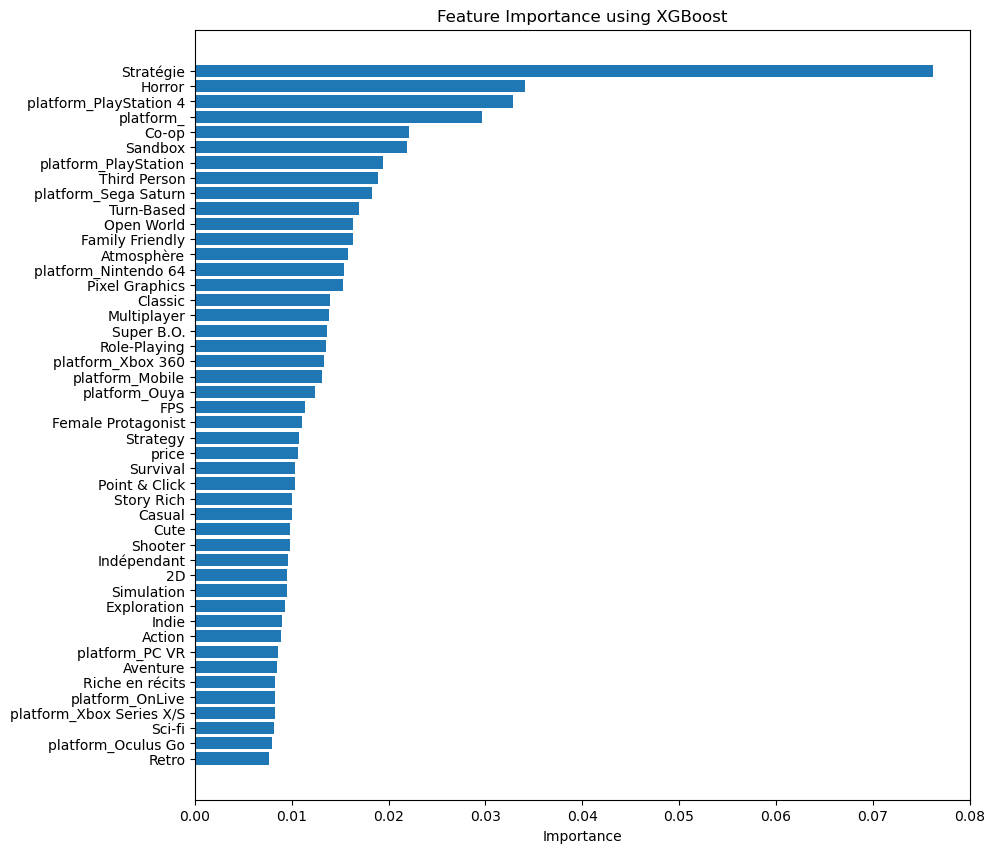

                      Feature  Importance
41                  Stratégie    0.076234
17                     Horror    0.034099
77     platform_PlayStation 4    0.032806
52                  platform_    0.029673
12                      Co-op    0.022076
47                    Sandbox    0.021943
144      platform_PlayStation    0.019391
50               Third Person    0.018897
153      platform_Sega Saturn    0.018292
42                 Turn-Based    0.016896
33                 Open World    0.016316
28            Family Friendly    0.016287
8                  Atmosphère    0.015756
70       platform_Nintendo 64    0.015426
43             Pixel Graphics    0.015250
11                    Classic    0.013976
20                Multiplayer    0.013888
51                 Super B.O.    0.013658
38               Role-Playing    0.013576
109         platform_Xbox 360    0.013290
86            platform_Mobile    0.013133
94              platform_Ouya    0.012437
131      platform_Sega Saturn    0

In [33]:
### Avec les genres réduits 

# Charger les données
df = pd.read_csv('../Donnees/cleaned_data.csv')
dataset = df[['platform', 'genres', 'date', 'price','time','rating']].copy()

# Préparer les données
dataset = dataset.dropna(subset=['rating', 'genres', 'platform', 'date', 'price'])
dataset['genres'] = dataset['genres'].apply(ast.literal_eval)
dataset['platform'] = dataset['platform'].apply(ast.literal_eval)

# One-hot encoding des colonnes 'genres' et 'platform'
genres_df = reduce_genre_columns(dataset,50)
platforms_df = pd.get_dummies(pd.DataFrame(dataset['platform'].tolist()), prefix='platform', prefix_sep='_')

# Concaténer les genres et plateformes au DataFrame original
dataset = pd.concat([dataset, genres_df, platforms_df], axis=1)

# Supprimer les colonnes originales
dataset = dataset.drop(columns=['genres', 'platform'])

# Extraire l'année de la colonne 'date'
dataset['year'] = pd.to_datetime(df['date']).dt.year
dataset = dataset.drop(columns=['date'])

# Définir les caractéristiques et la cible
X = dataset.drop(columns=['rating'])
y = dataset['rating']

# Scaler les caractéristiques numériques
numeric_features = ['price', 'year']
numeric_transformer = StandardScaler()

# Créer un préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)],
    remainder='passthrough')

# Split des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer le pipeline avec préprocesseur et modèle XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

# Entraîner le modèle
pipeline.fit(X_train, y_train)

# Évaluer l'importance des caractéristiques
feature_importances = pipeline.named_steps['model'].feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Trier par importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(50)

# Afficher les importances
plt.figure(figsize=(10, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance using XGBoost')
plt.gca().invert_yaxis()
plt.show()

print(importance_df)

### Prédiction du retirement en fonction du rating, de la plateforme, du genre, de la date et du prix

In [58]:
from sklearn.ensemble import RandomForestRegressor

# Preprocessing
X = df[['rating',"pourcentage_pos", 'platform', 'genres', 'date', 'price','time',"twenty_four_hours","all_time"]]
y = df['retirement']

X = X_with_dummies_genre_platform(X)

X = X.drop(index=np.where(outliers==-1)[0])
y = y.drop(index=np.where(outliers==-1)[0])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict retirement on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')



Mean Squared Error: 13.819787554371002
R-squared: 0.3891030871602107


## Recommandation

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Chargement du DataFrame
df = pd.read_csv('../Donnees/cleaned_data.csv')  # Remplacez par le chemin vers votre fichier CSV

# Combinaison des colonnes de texte pertinentes pour la similarité (titre, description, genres)
df['combined_features'] = df['title'] + " " + df['description'] + " " + df['genres']
df = df.dropna()
# Vectorisation des textes
vectorizer = TfidfVectorizer(stop_words='english')

tfidf_matrix = vectorizer.fit_transform(df['combined_features'])

# Standardisation des colonnes numériques (rating, price, etc.)
numerical_features = ['rating', 'price', 'pourcentage_pos', 'review_count', 'rating_value']
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(df[numerical_features])

# Concatenation des matrices de texte et des caractéristiques numériques
features_matrix = np.hstack((tfidf_matrix.toarray(), scaled_numerical))

# Calcul de la similarité cosinus
similarity_matrix = cosine_similarity(features_matrix)

In [37]:
def recommend_games(liked_games, df, similarity_matrix, top_n=10):
    # Trouver les indices des jeux aimés
    liked_indices = []
    for game in liked_games:
        liked_indices.append(int(np.where(df['title']==game)[0]))

    # Calculer la similarité moyenne pour les jeux aimés
    mean_similarity = np.mean(similarity_matrix[liked_indices], axis=0)

    # Trouver les indices des jeux les plus similaires, en excluant les jeux déjà aimés
    similar_indices = mean_similarity.argsort()[::-1]
    similar_indices = [i for i in similar_indices if df.iloc[i]['title'] not in liked_games]

    # Retourner les titres des jeux recommandés
    recommended_games = df.iloc[similar_indices[:top_n]]['title'].values
    return recommended_games

# Jeux aimés par le joueur
liked_games = ['7 Wonders II', 'Clue/Cluedo: The Classic Mystery Game', 'A Hat in Time']  

# Recommandations
recommended_games = recommend_games(liked_games, df, similarity_matrix, top_n=10)
print("Jeux recommandés :", recommended_games)


Jeux recommandés : ['Paint the Town Red' 'Grim Legends 2: Song of the Dark Swan'
 'Ding Dong XL' "D'LIRIUM" 'Beat Hazard' 'Streets of Rogue' 'Bejeweled 3'
 'Enigmatis: The Mists of Ravenwood' 'Alien Shooter'
 'Airships: Conquer the Skies']


## Clusters

In [64]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X = df[['platform', 'genres', 'rating']]
X = X_with_dummies_genre_platform(X)
X = X.dropna()
#scaler = StandardScaler()  # Standardize numerical variables
#X_scaled = scaler.fit_transform(X_encoded)



c:\Users\rapha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


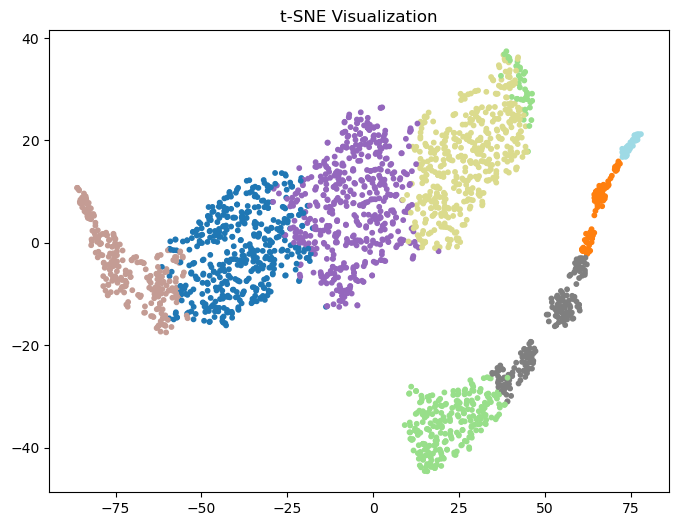

In [65]:
# t-SNE
from sklearn.manifold import TSNE

tab20 = plt.get_cmap('tab20')

km = KMeans(n_clusters=5)
km.n_clusters = 8
pred = km.fit_predict(X)

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=pred, cmap='tab20', s=10)
plt.title('t-SNE Visualization')
plt.show()

# Explicabilité